In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib.pyplot as plt
from collections import OrderedDict 
import time
np.set_printoptions(threshold=sys.maxsize)

In [2]:
trueHitsPath = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5"
digiHitsPath = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5"

trueHitsFile = h5py.File(trueHitsPath,"r")
digiHitsFile =h5py.File(digiHitsPath,"r")

#Look at event ids
n = 100000
trueEvents = trueHitsFile["event_ids"][:n]
digiEvents = digiHitsFile["event_ids"][:n]

trueEventHits = trueHitsFile["event_hits_index"][:n]
digiEventHits = digiHitsFile["event_hits_index"][:n]

print(len(trueHitsFile["event_ids"]))
print(len(digiHitsFile["event_ids"]))

print(trueEvents[:100])
print(digiEvents[:100])

#print(np.where(digiEvents==9)[0][0])
print(digiEvents[:3000])
print(digiEvents[2999])

3000000
2868354
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[  0   1   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  59  60  63  64  65  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95  96
  97  98 100 101 102 103 104 105 106 107]
[   0    1    2    3    4    5    6    7    8   10   11   13   14   15
   16   17   18   19   20   21   22   23   24   25   26   27   28   29
   30   31   32   33   34   35   36   37   38   39   40   41   42   43
   44   45   46   47   48   49   50   51   52   53   54   

In [5]:
####### Generate true hits offset array and digi hits offset array

####Example (ignore)
#trueHitIndices = [0, 80, 160, 240, 320, 400, 480, 560, 640, 720, 800 ]
#digiHitIndices = [0, 100, 200, 300, 400, 500, 600, 700, 800, -1, 1000]

#Alternative method is to remove the non-matching entry from truehit -> would not have to add -1 to digiHit

#Look at event ids
n = 400000
trueEvents = trueHitsFile["event_ids"][:n]
digiEvents = digiHitsFile["event_ids"][:n]

trueEventHits = trueHitsFile["event_hits_index"][:n]
digiEventHits = digiHitsFile["event_hits_index"][:n]


#Make all event_ids unique (since they reset at 3000)
digiTemp = digiEvents
for i in range(len(digiEvents)):
    if(i != 0 and digiEvents[i] < digiEvents[i-1]):
        digiTemp[i:] = digiTemp[i:] + 3000
        
        
#Create digitized hit offset array
#Null entries are given a value of -1
#The index of the entry corresponds to its event id (ie at index 10, we get the pmt hit offset value for event 10)
digiHitsOffset = []
for i in range(len(trueEvents)):
        
    try:
        index = np.where(digiTemp == i)[0][0]
        digiHitsOffset.append(digiEventHits[index])
    except:
        digiHitsOffset.append(-1)
 
        
print(len(digiHitsOffset))

np.save('digiHitsOffsetArr.npy', digiHitsOffset)
        

400000


In [4]:
#### Test loading array ####

digiArr = np.load("digiHitsOffsetArr.npy")

print(len(digiArr))
print(digiArr[:15])

100000
[    0   925  1384  2506  3330  5958  7357  7738  9999    -1 10660 11790
    -1 12012 12990]


In [33]:
#Load pmt hit information from both true source and digitized source
trueHitPmt    = trueHitsFile["hit_pmt"]
trueHitTime   = trueHitsFile["hit_time"]
trueHitParent = trueHitsFile["hit_parent"]

digiHitPmt    = digiHitsFile["hit_pmt"]
digiHitTime   = digiHitsFile["hit_time"]
digiHitCharge = digiHitsFile["hit_charge"]

#Notice that there are more true hit pmts than digitized hit pmts
#This is because they do not surpass the threshold
print(len(trueHitPmt))
print(len(digiHitPmt))

11865355642
4607347439


True hit # pmts:  1458
Digitized hit # pmts:  1313
Charge Comparison:  2251 2149.814
1313


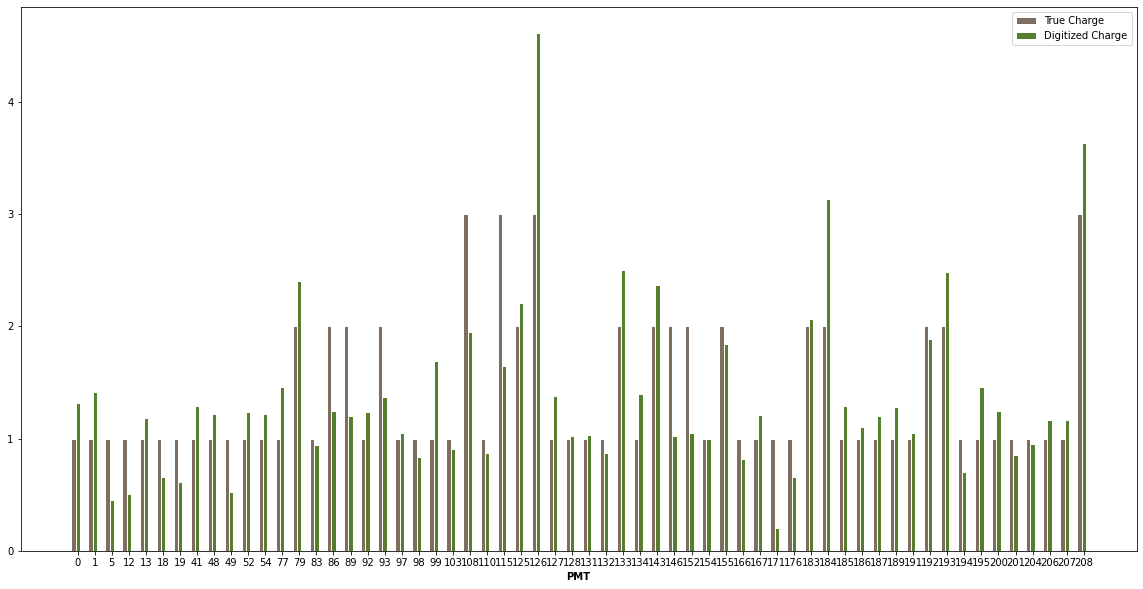

% Difference between true and digitzed charge:  28.189


In [148]:
######## Analyse a specific event ############

## NOTE: pretty sure there is a bug here, when looking for the "last event"
# there is a difference between true and digitized since digitized skips some events.
# Need to clarify this before fixing.

event = 76
#Find the starting index
digiIndex = np.where(digiEvents==event)[0][0]
trueIndex = np.where(trueEvents==event)[0][0]
startDigiIndex = digiHitsFile["event_hits_index"][digiIndex]
startTrueIndex = trueHitsFile["event_hits_index"][trueIndex]

#Find the ending true/digitize indices for each event
endDigiIndex = digiHitsFile["event_hits_index"][digiIndex+1]
endTrueIndex = trueHitsFile["event_hits_index"][trueIndex+1]

#Retrieve array of corresponding hit pmt's (indices will be different)
digiHitPmt = digiHitsFile["hit_pmt"][startDigiIndex:endDigiIndex]
trueHitPmt = trueHitsFile["hit_pmt"][startTrueIndex:endTrueIndex]
    
#Vectorized operation to count the number of instances of each unique true hit pmt there are
#This counts_elements array should very closely match up with the charge on the corresponding pmts
uniqueElements, countsElements = np.unique(trueHitPmt, return_counts=True)

#Check difference in true hit pmts vs digitized hit pmts
print("True hit # pmts: ",len(uniqueElements))
print("Digitized hit # pmts: ",len(digiHitPmt))

#Compare total charge across all pmts for true vs digitized cases
trueSum = np.sum(countsElements)
digiSum = np.sum(digiHitsFile["hit_charge"][startDigiIndex:endDigiIndex])

print("Charge Comparison: ",trueSum, digiSum)

#We can sort and intersect the arrays to find only pmts that pass the criteria for digitized hits
#Still needs work here to map correctly
intersectionArr = np.intersect1d(digiHitPmt,uniqueElements)
print(len(intersectionArr)) #We notice that this is now the same as the digitized hits, down from true pmt number

##### Create true and digi dictionaries #####
digiHitCharge = digiHitsFile["hit_charge"][startDigiIndex:endDigiIndex]

#Digitized dictionary
digiDict = dict(zip(digiHitPmt,digiHitCharge))
digiDict = dict(sorted(digiDict.items())) 
#print(digiDict)
#
#True dictionary
trueDict = dict(zip(uniqueElements,countsElements))
trueDict = {x: trueDict[x] for x in digiDict.keys()}
#print(trueDict)


##### Plotting the first n pmts from a specific event #####

# set width of bar
barWidth = 0.25
n = 60

# Set position of bar on X axis
r1 = np.arange(len(list(trueDict.values())[:n]))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(r1, list(trueDict.values())[:n], color='#7f6d5f', width=barWidth, edgecolor='white', label='True Charge')
plt.bar(r2, list(digiDict.values())[:n], color='#557f2d', width=barWidth, edgecolor='white', label='Digitized Charge')
 
# Add xticks on the middle of the group bars
plt.xlabel('PMT', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(list(trueDict.keys())[:n]))], list(trueDict.keys())[:n])
 
# Create legend & Show graphic
plt.legend()
plt.show()

### Calculate the mean abs error % between true and digitized hits across all common pmts ###
sumVals = 0
for pmt in trueDict.keys():
    sumVals += abs((trueDict[pmt]-digiDict[pmt])/trueDict[pmt])
diff = sumVals/len(trueDict.keys())
print("% Difference between true and digitzed charge: ", round(diff*100,3))